# Lale: Library for Semi-Automated Data Science

Martin Hirzel, Kiran Kate, Avi Shinnar, Guillaume Baudart, and Pari Ram

5 November 2019

Examples, documentation, code: https://github.com/ibm/lale

<img src="../docs/img/lale_logo.jpg" alt="logo" width="140px" align="left"/>

This notebook is the basis for a
[talk](https://pydata.org/nyc2019/schedule/presentation/29/type-driven-automated-learning-with-lale/)
about [Lale](https://github.com/ibm/lale).  Lale is an open-source
Python library for semi-automated data science. Lale is compatible
with scikit-learn, adding a simple interface to existing
machine-learning automation tools. Lale lets you search over possible
pipelines in just a few lines of code while remaining in control of
your work.

## Value Proposition

When writing machine-learning pipelines, you have a lot of decisions
to make, such as picking transformers, estimators, and
hyperparameters. Since some of these decisions are tricky, you will
likely find yourself searching over many possible pipelines.
Machine-learning automation tools help with this search.
Unfortunately, each of these tools has its own API, and the search
spaces are not necessarily consistent nor even correct. We have
discovered that types (such as enum, float, or dictionary) can both
check the correctness of, and help automatically search over,
hyperparameters and pipeline configurations.

To address this issue, we have open-sourced Lale, an open-source
Python library for semi-automated data science. Lale is compatible
with scikit-learn, adding a simple interface to existing
machine-learning automation tools.
Lale is designed to augment, but not replace, the data scientist.

The **target user** of Lale is the working data scientist.
The **scope** of Lale includes machine learning (both deep learning
and non-DL) and data preparation. The **value** of Lale encompasses:

<img src="img/2019-1105-three-values.png" style="width:350px" align="left">

## Categorical + Continuous Dataset

To demonstrate automated machine learning (AutoML), we first need
a dataset. We will use a tabular dataset that has two kinds of
features: categorical features (columns that can contain one of a
small set of strings) and continuous features (numerical columns).  In
particular, we use the `credit-g` dataset from OpenML. After fetching
the data, we display a few rows to get a better understanding of its
labels and features.

In [1]:
!pip install 'liac-arff>=2.4.0'

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import lale.datasets.openml
import pandas as pd
(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    'credit-g', 'classification', preprocess=False)
# print last five rows of labels in train_y and features in train_X
pd.options.display.max_columns = None
pd.concat([train_y.tail(5), train_X.tail(5)], axis=1)

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
835,bad,<0,12.0,no credits/all paid,new car,1082.0,<100,1<=X<4,4.0,male single,none,4.0,car,48.0,bank,own,2.0,skilled,1.0,none,yes
192,bad,0<=X<200,27.0,existing paid,business,3915.0,<100,1<=X<4,4.0,male single,none,2.0,car,36.0,none,own,1.0,skilled,2.0,yes,yes
629,good,no checking,9.0,existing paid,education,3832.0,no known savings,>=7,1.0,male single,none,4.0,real estate,64.0,none,own,1.0,unskilled resident,1.0,none,yes
559,bad,0<=X<200,18.0,critical/other existing credit,furniture/equipment,1928.0,<100,<1,2.0,male single,none,2.0,real estate,31.0,none,own,2.0,unskilled resident,1.0,none,yes
684,good,0<=X<200,36.0,delayed previously,business,9857.0,100<=X<500,4<=X<7,1.0,male single,none,3.0,life insurance,31.0,none,own,2.0,unskilled resident,2.0,yes,yes


The labels `y` are either 0 or 1, which means that this is a binary
classification task. The remaining 20 columns are features. Some of the
features are categorical, such as `checking_status` or
`credit_history`. Other features are continuous, such as `duration` or
`credit_amount`.

## Manual Pipeline

Lale is designed to support both manual and automated data science,
with a consistent API that works for both of these cases as well as
for the spectrum of semi-automated cases in between. A
machine-learning *pipeline* is a computational graph, where each
node is an *operator* (which transforms data or makes predictions)
and each edge is an intermediary *dataset* (outputs from previous
operators are piped as inputs to the next operators). We first import
some operators from scikit-learn and ask Lale to wrap them for us.

In [3]:
from sklearn.preprocessing import Normalizer as Norm
from sklearn.preprocessing import OneHotEncoder as OneHot
from sklearn.linear_model import LogisticRegression as LR
import lale
lale.wrap_imported_operators()

The next cell imports a couple of utility operators from Lale's
standard library.

In [4]:
from lale.lib.lale import Project
from lale.lib.lale import ConcatFeatures as Concat

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/usr/local/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


Now that we have all the operators we need, we arrange them into a
pipeline. The `Project` operator works like the corresponding
relational algebra primitive, picking a subset of the columns of the
dataset. An sub-pipeline of the form `op1 >> op2` *pipes* the output
from `op1` into `op2`. An sub-pipeline of the form `op1 & op2` causes
both op1 *and* op2 to execute on the same data. The overall pipeline
preprocesses numbers with a normalizer and strings with a one-hot
encoder, then concatenates the corresponding columns and pipes the
result into an `LR` classifier.

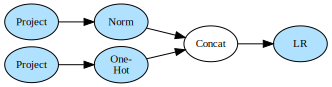

In [5]:
manual_trainable = (
       (  Project(columns={'type': 'number'}) >> Norm()
        & Project(columns={'type': 'string'}) >> OneHot())
    >> Concat
    >> LR(LR.enum.penalty.l2, C=0.001))
manual_trainable.visualize()

In this example, we have manually chosen all operators and configured
their hyperparameters. For the `LR` operator, we configured the
penalty hyperparameter with `l2` and the regularization constant `C`
with `0.001`. Depending on what tool you use to you view this notebook,
you can explore these hyperparameters by hovering over
the visualization above and observing the tooltips that pop up.
Furthermore, each node in the visualization is a hyperlink that takes
you to the documentation of the corresponding operator.  Calling `fit`
on the trainable pipeline returns a trained pipeline, and calling
`predict` on the trained pipeline returns predictions. We can use
off-the-shelf scikit-learn metrics to evaluate the result. In this
case, the accuracy is poor.

In [6]:
import sklearn.metrics
manual_trained = manual_trainable.fit(train_X, train_y)
manual_y = manual_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, manual_y):.1%}')

accuracy 70.9%


## Pipeline Combinators

As the previous example demonstrates, Lale provides combinators `>>`
and `&` for arranging operators into a pipeline. These combinators are
actually syntactic sugar for functions `make_pipeline` and
`make_union`, which were inspired by the corresponding functions in
scikit-learn. To support AutoML, Lale supports a third combinator `|`
that specifies an algorithmic choice. Scikit-learn does not have a
corresponding function. Various AutoML tools support algorithmic
choice in some form or other, using their own tool-specific syntax.
Lale's `|` combinator is syntactic sugar for Lale's `make_choice`
function.

| Lale feature            | Name | Description  | Scikit-learn feature                |
| ----------------------- | ---- | ------------ | ----------------------------------- |
| >> or `make_pipeline`   | pipe | feed to next | `make_pipeline`                     |
| & or `make_union`       | and  | run both     | `make_union` or `ColumnTransformer` |
| &#x7c; or `make_choice` | or   | choose one   | N/A (specific to given AutoML tool) |

## Automated Pipeline

Next, we will use automation to search for a better pipeline for the
`credit-g` dataset. Specifically, we will perform combined
hyperparameter optimization and algorithm selection (CASH). To do
this, we first import a couple more operators to serve as choices in
the algorithm selection.

In [7]:
from xgboost import XGBClassifier as XGBoost
from sklearn.svm import LinearSVC
lale.wrap_imported_operators()

Next, we arrange the pipeline that specifies the search space for
CASH. As promised, the look-and-feel for the automated case resembles
that for the manual case from earlier. The main difference is the use
of the `|` combinator to provide algorithmic choice
(`LR | XGBoost | LinearSVC`). However, there is another difference: several of the
operators are not configured with hyperparameters. For instance, this
pipeline writes `LR` instead of `LR(LR.penalty.l1, C=0.001)`.
Omitting the arguments means that as the data scientist, we do not
bind the hyperparameters by hand in this pipeline. Instead, we leave
these bindings free for CASH to search over. Similarly, the code
contains `Norm` instead of `Norm()` and `OneHot` instead of `OneHot()`.
This illustrates that automated hyperparameter tuning can be used not
only on the final classifier but also inside of nested preprocessing
sub-pipelines.

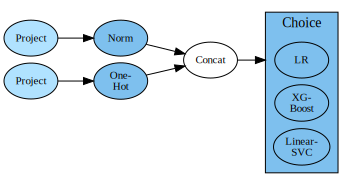

In [8]:
auto_planned = (
       (  Project(columns={'type': 'number'}) >> Norm
        & Project(columns={'type': 'string'}) >> OneHot)
    >> Concat
    >> (LR | XGBoost | LinearSVC))
auto_planned.visualize()

The colors in the visualization indicate the particular mix of manual
vs. automated bindings and will be explained in more detail below.
For now, we look at how to actually invoke an AutoML tool from Lale.
Lale provides bindings for multiple such tools; here we use the
popular hyperopt open-source library. Specifically,
`Hyperopt` takes the `auto_planned` pipeline from above as
an argument, along with optional specifications for the number of
cross-validation folds and trials to run. Calling `fit` yields a
trained pipeline. The code that uses that trained pipeline for
prediction and evaluation is the same as in the manual use case we saw
before.

In [9]:
from lale.lib.lale.hyperopt import Hyperopt
auto_optimizer = Hyperopt(estimator=auto_planned, cv=3, max_evals=10)
auto_trained = auto_optimizer.fit(train_X, train_y)
auto_y = auto_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, auto_y):.1%}')

[15:01:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:02:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

The predictive performance is better, and in fact, it is in the same
ball-park as the state-of-the-art performance reported for this
dataset in OpenML. Since we left various choices to automation, at
this point, we probably want to inspect what the automation chose
for us. One way to do that is by visualizing the pipeline as before.
This reveals that hyperopt chose `XGBoost` instead of the scikit-learn
classifiers. Also, by hovering over the nodes in the visualization, we
can explore how hyperopt configured the hyperparameters. Note that all
nodes are visualized in white to indicate they are fully trained.

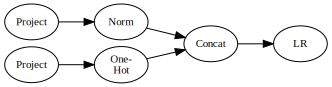

In [10]:
auto_trained.get_pipeline().visualize()

Another way to inspect the results of automation is to pretty-print
the trained pipeline back as Python source code. This lets us look at
the output of automation in the same syntax we used to specify
the input to automation in the first place.

In [11]:
auto_trained.get_pipeline().pretty_print(ipython_display=True, show_imports=False)

```python
project_0 = Project(columns={"type": "number"})
norm = Norm(norm="max")
project_1 = Project(columns={"type": "string"})
lr = LR(
    fit_intercept=False,
    intercept_scaling=0.38106476479749274,
    max_iter=422,
    multi_class="multinomial",
    solver="saga",
    tol=0.004851580781685862,
)
pipeline = ((project_0 >> norm) & (project_1 >> OneHot())) >> Concat() >> lr
```

## Bindings as Lifecycle

The previous example already alluded to the notion of bindings and
that those bindings are reflected in node visualization colors.
Bindings here relate to the mathematical notion of free or bound
variables in formulas. *Bindings as lifecycle* is one of the fundamental
novel concepts around which we designed Lale. Lale distinguishes two
kinds of operators: *individual operators* are data-science primitives
such as data preprocessors or predictive models, whereas *pipelines*
are compositions of operators. Each operator, whether individual or
composite, can be in one of four lifecycle states: meta-model,
planned, trainable, and trained. The lifecycle state of an operator is
defined by which bindings it has. Specifically:

- *Meta-model*: Individual operators at the meta-model state have
  schemas and priors for their hyperparameters. Pipelines at the
  meta-model state have steps (which are other operators) and a
  grammar.

- *Planned*: To get a planned pipeline, we need to *arrange* it by
  binding a specific graph topology. This topology is consistent with
  but more concrete than the steps and grammar from the meta-model
  state.

- *Trainable*: To get a trainable individual operator, we need to
  initialize the concrete bindings for its hyperparameters.
  Scikit-learn does this using `__init__`; Lale emulates that syntax
  using `__call__`. To get a trainable pipeline, we need to bind
  concrete operator choices given by the `|` combinator.

- *Trained*: To get a trained individual operator, we need to *fit* it
  to the data, thus binding its learnable coefficients. A trained
  pipeline is like a trainable pipeline where all steps are trained.
  More generally, the lifecycle state of a pipeline is limited by the
  least upper bound of the states of its steps.

<img src="img/2019-1105-bindings.png" style="width:450px" align="left">

The interested reader can explore Lale's concept of bindings as
lifecycle in more detail in our
[paper](https://arxiv.org/pdf/1906.03957.pdf).

The above diagram is actually a Venn diagram. Each lifecycle state is
a subset of its predecessor. For instance, a trained operator has all
the bindings of a planned operator and in addition also binds learned
coefficients. Since a trained operator has all bindings required for
being a trainable operator, it can be used where a trainable operator
is expected. Thus, the set of trained operators is a subset of the set
of trainable operators. This relationship between the lifecycle states is
essential for offering a flexible semi-automated data science
experience.

## Semi-Automated Data Science

Why would data scientists prefer semi-automation over full automation?
The main reason is to excert control over what kind of pipelines they
find. Below are several scenarios motivating semi-automated data
science.

| Manual control over automation      | Examples |
| ----------------------------------- | -------- |
| Restrict available operator choices | Interpretable, or based on licenses, or based on GPU requirements, ... |
| Tweak graph topology                | Custom preprocessing, or multi-modal data, or fairness mitigation, ... |
| Tweak hyperparametrer schemas       | Adjust range for continuous, or restrict choices for categorical, ... |
| Expand available operator choices   | Wrap existing library, or write your own operators, ... |

In fact, we envision that this will often happen via trial-and-error,
where you as the data scientist specify a first planned pipeline, let
AutoML do its search, then inspect the results, edit your code, and
try again. You already saw some of the Lale features for inspecting
the results of automation above. Lale further supports this
workflow by letting you specify *partial bindings* of some
hyperparameters while allowing other to remain free, and by letting
you *freeze* an operator at the trainable or trained state.

<img src="img/2019-1105-semi-automated.png" style="width:700px" align="left">

## 20 Newsgroups Dataset

For the next examples in this notebook, we will need a different
dataset. The following code fetches the 20 newsgroups data, using a
function that comes with scikit-learn. Then, it prints a
representative sample of the labels and features.

In [12]:
import sklearn.datasets
news = sklearn.datasets.fetch_20newsgroups()
news_X, news_y = news.data, news.target
pd.DataFrame({'y': [news.target_names[i] for i in news_y], 'X': news_X}).head()

,y,X
0,rec.autos,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,comp.sys.mac.hardware,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,comp.sys.mac.hardware,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,comp.graphics,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,sci.space,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


The labels `y` are strings taken from a set of 20 different newsgroup
names. That means that this is a 20-way classification dataset. The
features `X` consist of a single string with a message posted to one
of the newsgroups. The task is to use the message to predict which
group it was posted on.

## Constraints in Scikit-learn

As implied by the title of this notebook and the corresponding talk,
Lale is built around the concept of types. In programming languages, a
*type* specifies a set of valid values for a variable (e.g., for a
hyperparameter).  While types are in the foreground of some
programming languages, Python keeps types more in the background.
Python is dynamically typed, and libraries such as
scikit-learn rely more on exceptions than on types for their error
checking. To demonstrate this, we first import some scikit-learn
modules.

In [13]:
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.linear_model

Next, we create a scikit-learn pipeline, using fully qualified names
to ensure and clarify that we are not using any Lale facilities. The
pipeline consists of just two operators, a TFIDF transformer for
extracting features from the message text followed by a
logistic regression for classifying the message by newsgroup.

In [14]:
sklearn_misconfigured = sklearn.pipeline.make_pipeline(
    sklearn.feature_extraction.text.TfidfVectorizer(),
    sklearn.linear_model.LogisticRegression(solver='sag', penalty='l1'))
print('no error detected yet')

no error detected yet


The above code actually contains a mistake in the hyperparameters for
`LogisticRegression`. Unfortunately, scikit-learn does not detect this
mistake when the hyperparameters are configured in the code. Instead,
it delays its error checking until we attempt to fit the pipeline to
data.

In [15]:
%%time
import sys
try:
    sklearn_misconfigured.fit(news_X, news_y)
except ValueError as e:
    print(e, file=sys.stderr)

CPU times: user 3.45 s, sys: 92.9 ms, total: 3.54 s
Wall time: 3.59 s


Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.


The above output demonstrates that scikit-learn takes a few seconds to
report the error. This is because it first trains the TFIDF
transformer on the data, and only when that is done, it attempts to
train the `LogisticRegression`, triggering the exception. While a few
seconds are no big deal, the 20 newsgroup dataset is small, and for larger
datasets, the delay is larger. Furthermore, while in this case, the
erroneous code is not far away from the code that triggers the error
report, for larger code bases, that distance is also further. The
error message is nice and clear about the erroneous hyperpareters, but
does not mention which operator was misconfigured (here,
`LogisticRegression`).

## Constraints in AutoML

The above example illustrates an exception caused by manually
misconfigured hyperparameters. Tools for automated machine learning
usually run many trials with different hyperparameter configurations.
Just as in the manual case, in general, some of these automated trials
may raise exceptions.

**Solution 1:** Unconstrained search space

- {solver: \[linear, sag, lbfgs\], penalty: \[l1, l2\]}
- catch exception (after some time)
- return made-up loss `np.float.max`

This first solution has the benefit of being simple, but the drawback
that it may waste computational resources on training upstream
operators before detecting erroneous downstream operators. It also
leads to a larger-than-necessary search space. While we can use a high
loss to steer the AutoML tool away from poorly performing points in
the search space, in our experiments, we have encountered cases where
this adversely affects convergence.

**Solution 2:** Constrained search space

- {solver: \[linear, sag, lbfgs\], penalty: \[l1, l2]\} **and** (**if** solver: [sag, lbfgs] **then** penalty: [l2])}
- no exceptions (no time wasted)
- no made-up loss

The second solution is the one we advocate in Lale. The Lale library
contains hyperparameter schemas for a large number of operators. These
schemas are type specifications that encode not just the valid values
for each hyperparameter in isolation, but also constraints cutting
across multiple hyperparameters such as `solver` and `penalty` in the
example.

## Constraints in Lale

To demonstrate how Lale handles constraints, we first import Lale's
wrapper for TFIDF. We need not import LogisticRegression here since we
already imported it earlier in the notebook.

In [16]:
from lale.lib.sklearn import TfidfVectorizer as Tfidf

Lale uses JSON Schema to express types. JSON Schema is a widely
supported and adopted standard proposal for specifying the valid
structure of JSON documents. By using JSON Schema for hyperparameters,
we avoided the need to implement any custom schema validation code.
Instead, we simply put the concrete hyperparameters into a JSON
document and then use an off-the-shelf validator to check that against
the schema.

In [17]:
%%time
import jsonschema
try:
    lale_misconfigured = Tfidf >> LR(LR.enum.solver.sag, LR.enum.penalty.l1)
except jsonschema.ValidationError as e:
    print(e.message, file=sys.stderr)

CPU times: user 23 ms, sys: 2.6 ms, total: 25.6 ms
Wall time: 25.5 ms


Invalid configuration for LR(solver='sag', penalty='l1') due to constraint the newton-cg, sag, and lbfgs solvers support only l2 or no penalties.
Schema of constraint 1: {
    "description": "The newton-cg, sag, and lbfgs solvers support only l2 or no penalties.",
    "anyOf": [
        {
            "type": "object",
            "properties": {
                "solver": {"not": {"enum": ["newton-cg", "sag", "lbfgs"]}}
            },
        },
        {
            "type": "object",
            "properties": {"penalty": {"enum": ["l2", "none"]}},
        },
    ],
}
Value: {'solver': 'sag', 'penalty': 'l1', 'dual': False, 'C': 1.0, 'tol': 0.0001, 'fit_intercept': True, 'intercept_scaling': 1.0, 'class_weight': None, 'random_state': None, 'max_iter': 100, 'multi_class': 'auto', 'verbose': 0, 'warm_start': False, 'n_jobs': None, 'l1_ratio': None}


The output demonstrates that the error check happened more than 100
times faster than in the previous example. This is because the code
did not need to train TFIDF. The error check also happened closer to
the root cause of the error, so the code dinstance is smaller.
Furthermore, the error message indicates
not just the wrong hyperparameters but also which operator was
misconfigured (here, `LR`).

## Schemas as Documentation

The above code example demonstrates that Lale uses JSON Schema for
error checking. But we can do better than just using schemas for one
purpose. Since all Lale operators carry hyperparameter schemas,
we can also use those same schemas for interactive documentation.  The
following code illustrates that by inspecting the schema of a
continuous hyperparameter.

In [18]:
XGBoost.hyperparam_schema('n_estimators')

{'description': 'Number of trees to fit.',
 'type': 'integer',
 'default': 100,
 'minimumForOptimizer': 50,
 'maximumForOptimizer': 1000}

Of course, the same interactive documentation approach also works for
categorical hyperparameters.

In [19]:
XGBoost.hyperparam_schema('booster')

{'description': 'Specify which booster to use.',
 'enum': ['gbtree', 'gblinear', 'dart', None],
 'default': None}

Using the same schemas for two purposes (validation and documentation)
makes them stronger. As a user, you can be confident that the
documentation you read is in sync with the error checks in the code.
Furthermore, while schemas check hyperparameters, the reverse is also
true: when tests reveal mistakes in the schemas themselves, they can
be corrected in a single location, thus improving both validation and
documentation.  However, we can do even better than using the same
schemas for two purposes: we can also use them for a third purpose
(automated search).

## Types as Search Spaces

The following picture illustrates how Lale uses types for AutoML.
The data scientist is shown on the left. They interact with a pipeline
at either the planned or trainable lifecycle state, or at some mixed
state as discussed above under semi-automated AutoML.  Every
individual operator in Lale carries types in the form of a schema.
Users rarely have to write these schemas by hand, since the Lale
library already includes schemas for, at last count, 133 individual
operators.  Given a planned pipeline, when the data scientist kicks
off a search, Lale automatically generates a search space appropriate
for the given combined algorithm selection and hyperparameter
optimization tool, e.g., hyperopt.  For each trial, the
CASH tool then acquires a point in the search space, e.g., using an
acquisition function in Bayesian optimization. Then, Lale
automatically decodes that search point into a trainable Lale
pipeline. By construction, this trainable pipeline validates against
the schemas. We can train and score the pipeline, usually with
cross-validation, to return a loss value to the CASH tool. If this
is the best pipeline found so far, the CASH tool will remember it
as the incumbent. When the search terminates, the CASH tool returns
the final incumbent, minimizing the loss. 
*Types as search spaces* is another fundamental
novel concept around which we designed Lale, described in more detail
in our [paper](https://arxiv.org/pdf/1906.03957.pdf).

<img src="img/2019-1105-search-spaces.png" style="width:700px" align="left">

## Customizing Schemas

While you can use Lale operators with their schemas as-is, you can
also customize the schemas to excert more control over the automation.
For instance, you might want to reduce the number of trees in an
XGBoost forest to reduce memory consumption or to improve
explainability. Or you might want to hand-pick one of the boosters
to reduce the search space and thus hopefully speed up the search.

In [20]:
import lale.schemas as schemas
Grove = XGBoost.customize_schema(
    n_estimators=schemas.Int(minimum=2, maximum=6),
    booster=schemas.Enum(['gbtree'], default='gbtree'))

As this example demonstrates, Lale provides a simple Python API for
writing schemas, which it then converts to JSON Schema internally.
The result of customization is a new copy of the operator that can be
used in the same way as any other operator in Lale. In particular,
it can be part of a pipeline as before.

In [21]:
grove_planned = ( Project(columns={'type': 'number'}) >> Norm
                & Project(columns={'type': 'string'}) >> OneHot
                ) >> Concat >> Grove

Given this new planned pipeline, we use hyperopt as before to search for a
good trained pipeline.

In [22]:
grove_optimizer = Hyperopt(estimator=grove_planned, cv=3, max_evals=10, verbose=True)
grove_trained = grove_optimizer.fit(train_X, train_y)
grove_y = grove_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, grove_y):.1%}')

[15:02:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:02:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:02:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:02:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[15:03:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
100%|██████████| 10/10 [00:24<00:00,  2.49s/trial, best loss: -0.7313420884048686]
[15:03:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy 73.0%


The result shows that the predictive performance is not quite as good
as before. As a data scientist, you can weigh that against other
needs, and possibly experiment more. Of course, you can also display
the result of automation, e.g., by pretty-printing it back as code.

In [23]:
grove_trained.get_pipeline().pretty_print(ipython_display=True, show_imports=False)

```python
project_0 = Project(columns={"type": "number"})
norm = Norm(norm="l1")
project_1 = Project(columns={"type": "string"})
grove = Grove(
    gamma=0.8726303533099419,
    learning_rate=0.7606845221791637,
    max_depth=2,
    min_child_weight=11,
    n_estimators=5,
    reg_alpha=0.5980470775121279,
    reg_lambda=0.2546844052569046,
    subsample=0.8142720284737895,
)
pipeline = (
    ((project_0 >> norm) & (project_1 >> OneHot())) >> Concat() >> grove
)
```

## Scikit-learn Compatible Interoperability

Scikit-learn has a big following, which is well-earned: it is one of the
most complete and most usable machine-learning libraries available.
In developing Lale, we spent a lot of effort on maintaining
scikit-learn compatibility. Earlier on, you already saw that Lale
pipelines work with off-the-shelf scikit-learn functions such as
metrics, and with other libraries such as XGBoost. To demonstrate
interoperability with additional libraries, we ran experiments with
pipelines from various different data modalities. For the movies
review text dataset, the best pipeline used a PyTorch implementation
of the BERT embedding.  For the car tabular dataset, the best pipeline
used a Java implementation of the J48 decision tree. For the CIFAR-10
images dataset, the best pipeline used a PyTorch implementation of a
ResNet50 neural network. And finally, for the epilepsy time-series
dataset, the best pipeline used a window transformer and voting
operator pair that was written for the task and then made available in
the Lale library. That demonstrates that Lale can use operators from
other libraries beyond scikit-learn and even from other languages than
Python. It also demonstrates that for some tasks, this interoperability
is necessary for better predictive performance.

<img src="img/2019-1105-interop.png" style="width:550px" align="left">

## Summary

Please check out the Lale github repository for examples,
documentation, and code: https://github.com/ibm/lale

This notebook started by listing three values that Lale provides:
automation, interoperability, and usability. Then, this notebook
introduced three fundamental concepts around which Lale is designed:
bindings as lifecycle, types as search spaces, and scikit-learn
compatible interoperability. As the following picture illustrates, the
three concepts sit at the intersection of the three values.

<img src="img/2019-1105-summary.png" style="width:350px" align="left">